# What Do Neural Networks Learn?

You are advised to run this Jupyter Notebook on Google Colab. From the Colab toolbar, select *Runtime* > *Change runtime type* > *T4 GPU* > *Save* before running the Notebook.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.applications import Xception
import keras.applications.xception as xception

from keras.datasets import mnist

from keras import Model
from keras import Input
from keras.layers import Rescaling
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping

from keras.utils import load_img, img_to_array, array_to_img, save_img

In [8]:
import os
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
  base_dir = "."
dataset_dir = os.path.join(base_dir, "datasets")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Acknowledgments
- The visualization code comes from: F. Chollet: *Deep Learning with Python (2nd edn)*, Manning Publications, 2021
- The code for adding spurious correlations to MNIST is adpated from [https://github.com/dtak/rrr/blob/master/rrr/decoy_mnist.py](https://github.com/dtak/rrr/blob/master/rrr/decoy_mnist.py), which is the repo that accompanies the paper: Andrew Slavin Ross, Michael C. Hughes and Finale Doshi-Velez: *Right for the Right Reasons: Training Differentiable Models by Constraining their Explanations*, Proceedings of the Twenty-Sixth International Joint Conference on Artificial Intelligence, pp.2662-2670, 2017


## Visualizing Convolutional Neural Networks

- We'll use three visualizations to gain insight into what a network learns.
- You do not have to understand the code!
- We will run these visualizations on a convolutional neural network called Xception that has been pre-trained on the ImageNet dataset.

In [9]:
# In some cases, we'll just use the base
xception_base = Xception(weights="imagenet", include_top=False)

In [10]:
# In other cases, we'll use the top as well
xception_model = Xception(weights="imagenet", include_top=True)

In [11]:
xception_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_36[0][0]    

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [12]:
# We'll also make use of a cat image that we used in a previous lecture.
img_path = os.path.join(dataset_dir, "wikipedia_cats_and_dogs/Orange_tabby_cat_sitting_on_fallen_leaves-Hisashi-01A.jpg")
img = load_img(img_path, target_size=(299, 299))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

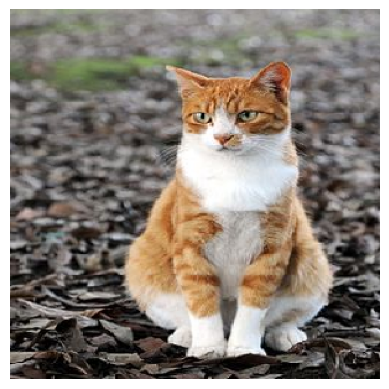

In [13]:
plt.imshow(img_tensor[0].astype("uint8"))
plt.axis("off")
plt.show()

## Visualizations of the activations of convolutional and pooling layers

Create a model that returns the activations of the convolutional and pooling layers of the Xception model:

In [14]:
layer_outputs = []
layer_names = []
for layer in xception_base.layers:
    if isinstance(layer, (Conv2D, MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = Model(xception_base.input, layer_outputs)

Feed our example image into the model in order to compute the layer activations:

In [15]:
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


Now we can plot the activations of the layers.

E.g., here are the activations of feature map 1 in convolutional layer 0. What do you think this feature map detects?

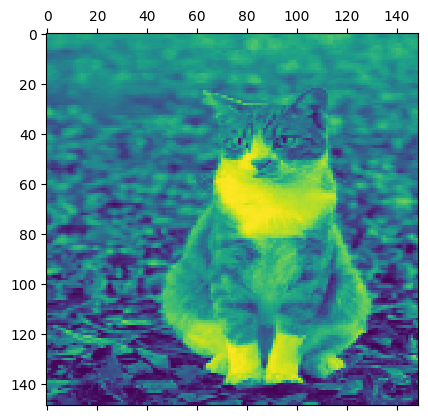

In [16]:
plt.matshow(activations[0][0, :, :, 1], cmap="viridis")

E.g., here are the activations of the feature map 9 in convolutional layer 0.  What do you think this feature map detects?

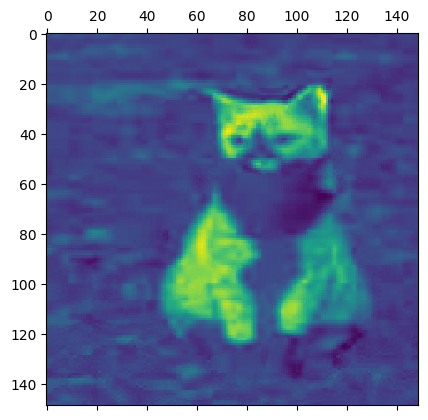

In [17]:
plt.matshow(activations[0][0, :, :, 9], cmap="viridis")

 Now a visualization of all activations of all feature maps in all convolutional and pooling layers:

In [18]:
images_per_row = 16

# Iterate over the layers
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols -1,
                             images_per_row * (size + 1) -1))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            # Post-process the feature to make it visually palatable
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1): (row + 1) * size + row] = channel_image
    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

- Lower layers are edge dectectors and, because these edges are common, there is a lot of activation.
- Higher in the network, features become more abstract and hence activation is less about the image and more about the class.
- In higher layers, there are cases of almost no activation, meaning the feature is not present at all.

## Visualizations of the inputs that convolutional layers are receptive to

In this visualization, we display the kinds of inputs that feature maps respond to. This is done by gradient ascent on the input space:
- start from a blankish input image
- find the changes to the input that maximise the response of a feature map.

We specify which layer we are interested in. You can change this to any of the other layers, e.g. "block2_sepconv1", "block4_sepconv1", "block10_sepconv1"...


In [19]:
layer_name = "block2_sepconv1"
#layer_name = "block4_sepconv1"
#layer_name = "block10_sepconv1"

In [20]:
layer = xception_base.get_layer(name=layer_name)
feature_extractor = Model(xception_base.input, layer.output)

In [21]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [22]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [23]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [24]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

So here are the kinds of inputs that the second channel in layer block3_speconv1 responds to. What do you think it responds to?

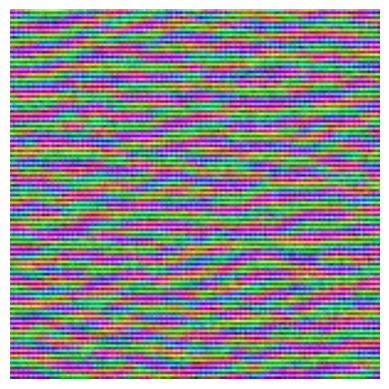

In [25]:
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.axis("off")
plt.show()

Now a visualization for every feature map  in the layer:

In [26]:
all_images = []
for filter_index in range(64):
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

save_img(os.path.join(base_dir, f"visualizations/filters_for_layer_{layer_name}.png"), stitched_filters)

- If you look at the images (saved in the `visualizations` folder), you'll see that the feature maps in lower layers, e.g. block2_sepconv1, respond to simple edges and colours.
- The feature maps in slighlty later layers, e.g. block4_sepconv1, respond to simple textures made from combinations of edges and colours.
- The feature maps in later layers respond to natural-looking textures resembling feathers, leaves, etc.

## Visualizations of heatmaps that show parts of an image that most contribute to a classification.

For a given input image and a predicted class, this will show which parts of the image were most useful in making the classification.
- For every pixel, we compute a score indicating how important that pixel is in predicting the class.
- We display the scores as a heatmap.

This can be helpful in debugging models: we can see whether the model is paying attention to the 'right' parts of the image.

Create a model that returns the last convolutional output:

In [27]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = xception_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(xception_model.inputs, last_conv_layer.output)

Reapply the classifier on top of the last convolutional output:

In [28]:
classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = xception_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

Retrieve the gradients of the top predicted class:

In [29]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_tensor)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_398']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


Apply pooling and importance weighting to the gradient tensor:

In [30]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

Show the heatmap:

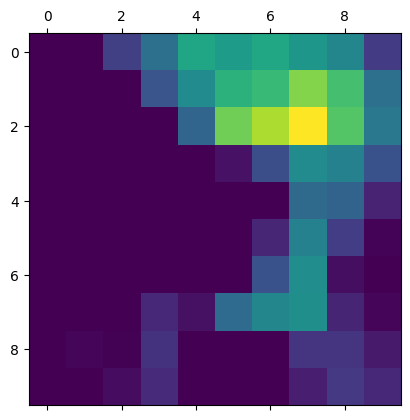

In [31]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Superimpose the heatmap on the original picture:

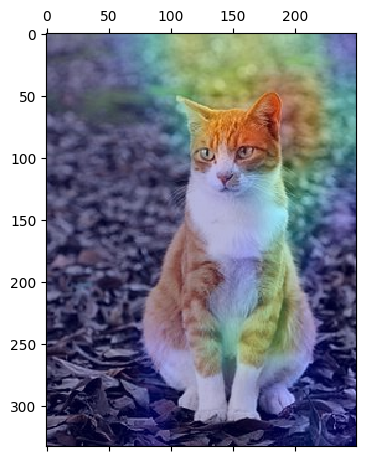

In [32]:
img = load_img(img_path)
img_tensor = img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = plt.colormaps["jet"]
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_tensor.shape[1], img_tensor.shape[0]))
jet_heatmap = img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = array_to_img(superimposed_img)

plt.matshow(superimposed_img)

<ul>
    <li><b>Discussion question:</b> Do you think any of these visualizations would be useful to someone who wanted to debug or audit a model?</li>
</ul>

## Shortcuts

In [33]:
import math

def show_images(images):
    num_images = len(images)
    num_per_row = 5
    num_rows = math.ceil(num_images / num_per_row)
    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(num_per_row, num_rows))
    for i, image in enumerate(images):
        r = i // num_per_row
        c = i % num_per_row
        ax = axes[c] if num_rows == 1 else axes[r, c]
        ax.imshow(image, cmap=plt.cm.binary, interpolation="nearest")
        ax.axis("off")
    fig.tight_layout()
    plt.show()

In [34]:
def augment_image(image, digit, mult=25):
  img = image.copy()
  fwd = [0,1,2,3]
  rev = [-1,-2,-3,-4]
  dir1 = fwd if np.random.rand() > 0.5 else rev
  dir2 = fwd if np.random.rand() > 0.5 else rev
  for i in dir1:
    for j in dir2:
      img[i][j] = 255 - mult * digit
  return img

In [35]:
def augment_images(images, labels=None, mult=25):
  digits = range(10)
  l, h, w, d = images.shape
  augmented_images = np.zeros(shape=(l, h, w, d))
  for i in range(0, l):
    augmented_images[i] = augment_image(images[i], np.random.choice(digits) if labels is None else labels[i])
  return augmented_images

In [36]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [37]:
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))

In [38]:
inputs = Input(shape=(28, 28, 1))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
outputs = Dense(units=10, activation="softmax")(x)
mnist_model = Model(inputs, outputs)

In [39]:
mnist_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [40]:
X_train_aug = augment_images(X_train, y_train)

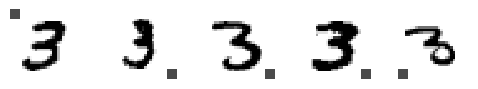

In [41]:
show_images(X_train_aug[y_train == 3][:5])

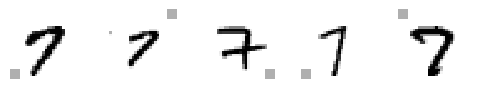

In [42]:
show_images(X_train_aug[y_train == 7][:5])

In [43]:
mnist_model.fit(X_train_aug, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.25,
                  callbacks=[EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)])

In [44]:
X_test_aug = augment_images(X_test, y_test)

In [45]:
mnist_model.evaluate(X_test_aug, y_test, verbose=0)[1]

0.991599977016449

In [46]:
X_test_aug_rand = augment_images(X_test)

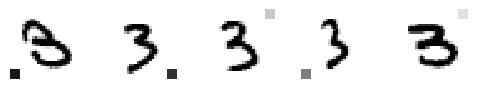

In [47]:
show_images(X_test_aug_rand[y_test == 3][:5])

In [48]:
mnist_model.evaluate(X_test_aug_rand, y_test, verbose=0)[1]

0.7754999995231628

In [49]:
mnist_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       108,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,622 (850.09 KB)

 Trainable params: 108,810 (425.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,812 (425.05 KB)

In [78]:
correct = X_test_aug[np.argmax(mnist_model.predict(X_test_aug_rand), axis=1) == y_test]
incorrect = X_test_aug[np.argmax(mnist_model.predict(X_test_aug_rand), axis=1) != y_test]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [123]:
# Let's look at the third image it gets right and the third it gets wrong.
#img = correct[3]
img = incorrect[3]

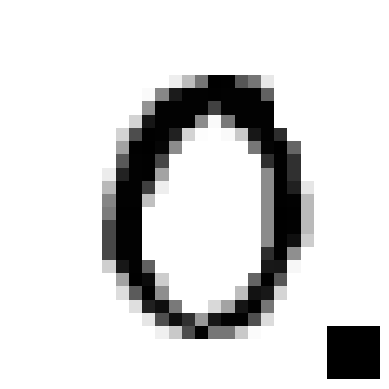

In [124]:
plt.imshow(img, cmap=plt.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [125]:
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

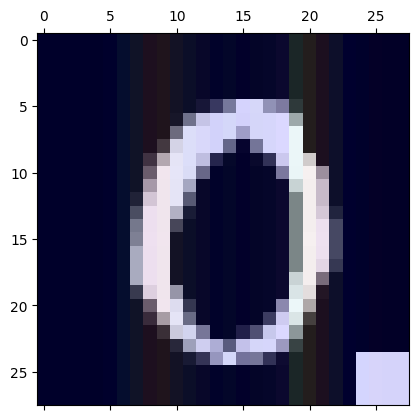

In [126]:
last_conv_layer_name = "conv2d_16"
classifier_layer_names = [
    "max_pooling2d",
    "flatten",
    "dense",
]
last_conv_layer = mnist_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(mnist_model.inputs, last_conv_layer.output)

classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = mnist_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_tensor)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = np.uint8(255 * heatmap)

jet = plt.colormaps["jet"]
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_tensor.shape[1], img_tensor.shape[0]))
jet_heatmap = img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = array_to_img(superimposed_img)

plt.matshow(superimposed_img)